# TF Generative Adversarial Networks
## Initialisation and dataset preparation

First, let us import the required libraries.

In [1]:
import tensorflow as tf
import numpy as np
from scipy.io import wavfile
from scipy.signal import spectrogram, stft, istft
import matplotlib.pyplot as plt
import librosa
import librosa.display
from misceallaneous import getWavFileAsNpArray, displaySpectrogram
from IPython.display import Audio
import tensorflow_gan as tfgan

Then, let us include the dataset.

The dataset is made of two files: `clean/p1.wav`and `white/p1.wav` which are converted into arrays of `int32` and then split into segments of `samples_length`.

The goal of the CGAN here is to predict the clean sample, when fed with the white one.

In [2]:
samplerate = 12000
nperseg = 1024

clean = getWavFileAsNpArray("../dataset_2/clean/p1.wav")
white = getWavFileAsNpArray("../dataset_2/white/p1.wav")
clean = np.array(clean, dtype="int32")
white = np.array(white, dtype="int32")

clean_dataset = []
white_dataset = []

samples_length = nperseg

for i in range(0, clean.shape[0]-samples_length, samples_length):
    clean_dataset.append(clean[i:i+samples_length])
    white_dataset.append(white[i:i+samples_length])
clean_dataset = np.array(clean_dataset)
white_dataset = np.array(white_dataset)

In [3]:
stft_clean_dataset_real = []
stft_clean_dataset_imag = []
stft_white_dataset_real = []
stft_white_dataset_imag = []

for i in clean_dataset:
    c, t, inp = stft(i, fs=samplerate, nperseg=nperseg)
    stft_clean_dataset_real.append(np.real(inp).T)
    stft_clean_dataset_imag.append(np.imag(inp).T)
    
for i in white_dataset:
    c, t, inp = stft(i, fs=samplerate, nperseg=nperseg)
    stft_white_dataset_real.append(np.real(inp).T)
    stft_white_dataset_imag.append(np.imag(inp).T)

stft_clean_dataset_real = np.array(stft_clean_dataset_real)
stft_clean_dataset_imag = np.array(stft_clean_dataset_imag)
stft_white_dataset_real = np.array(stft_white_dataset_real)
stft_white_dataset_imag = np.array(stft_white_dataset_imag)
print(stft_clean_dataset_real.shape, stft_clean_dataset_imag.shape, stft_white_dataset_real.shape, stft_white_dataset_imag.shape)

(10659, 3, 513) (10659, 3, 513) (10659, 3, 513) (10659, 3, 513)


In [4]:
data_shape = stft_clean_dataset_real.shape[1:]

In [5]:
def view_output(stft_white_dataset_real, gan, p):
    outputs = []
    for i in range(10):
        y = np.reshape(stft_white_dataset_real[i, :, :], (-1, stft_white_dataset_real.shape[1], stft_white_dataset_real.shape[2]))
        t, y1 = istft(np.reshape(gan.g.predict(y).T, data_shape[::-1])+np.imag(stft_white_dataset_imag[i]).T)
        y2 = np.reshape(y1.T, (clean_dataset.shape[1],))
        outputs.append(y2)
    b = np.concatenate(outputs)
    c, t, bxx = stft(b, fs=samplerate, nperseg=nperseg)
    displaySpectrogram(bxx)
    plt.savefig(str(p)+".png", format='png')

# CGAN Model
The main idea of a GAN model is to create two networks who play an adversarial game:
- A Generator, whose goal is to produce the most realistic samples possible to fool the Discriminator
- A Discriminator, whose goal is to correctly guess if its input is a real sample from the clean dataset or an output created by the Generator

A first model is saved in `'save2/gan_without_add'`. It does not have any add layer. It has been train on 3104 steps on 5000 samples of size 2048, visualizable in the folder `save2` gif.

A first model is saved in `'save2/gan_with_add'`. It does have an add layer. It has been train on 2475 steps on 10000 samples of size 1024, visualizable in the folder `save3` gif.

### Discriminator

The discriminator here uses a layer to process the Short-Time Fourier Transform (https://en.wikipedia.org/wiki/Short-time_Fourier_transform) before reducing the problem dimension to one single boolean prediction layer.

Interestingly, adding a Dropout layer on the input seems to prevent the generator to adapt itself to the little flaws of detection (which then only produces noise unrecognized by the discriminator).

In [6]:
def discriminator(input_shape):
    inputs = tf.keras.Input(shape=(input_shape[1], input_shape[2]))
    x = tf.keras.layers.Dropout(0.3)(inputs)
    #x3 = tf.keras.layers.Dense(512, activation="tanh")(x)
    x4 = tf.keras.layers.Dense(256, activation="tanh")(x)
    x5 = tf.keras.layers.Dense(128, activation="tanh")(x4)
    x6 = tf.keras.layers.Dense(1, activation="tanh")(x5)
    x7 = tf.keras.layers.Flatten()(x6)
    outputs = tf.keras.layers.Dense(1, activation="sigmoid")(x7)
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="discriminator")
    model.summary()
    model.compile(optimizer= 'adam', loss='bce', metrics=['accuracy'])
    return model

## Generator
The generator itself is a Convolutionnal Autoencoder.

Its input size and output size are both the size of the stft array.

In [41]:
def generator(sizes):
    inputs = tf.keras.Input(shape=(sizes[1], sizes[2]))
    x = tf.keras.layers.Dropout(0.3)(inputs)
    x1 = tf.keras.layers.Dense(10, activation='tanh')(x)
    x4 = tf.keras.layers.Dense(sizes[2], activation='tanh')(x1)
    x5 = tf.keras.layers.Add()([inputs, x4])
    outputs = tf.keras.layers.Dense(sizes[2], activation='linear')(inputs)
    
    model = tf.keras.Model(inputs=inputs, outputs=outputs, name="autoencoder")
    model.summary()
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    return model

In [42]:
def evaluate_generator(g, inputs, outputs, size=100):
    res = 0
    s = min(size, inputs.shape[0])
    for i in range(s):
        error = (g.predict(np.reshape(inputs[i], (-1, inputs[i].shape[0], inputs[i].shape[1])))-outputs[i])**2
        res += np.sum(error)
    return res/(s*100000000)

## Building the GAN

In [43]:
def get_generator_outputs(white, train_size, g, nperseg, clean):
    steps = train_size//20
    rng = np.random.default_rng()
    g_outputs = []
    batch = rng.choice(white, train_size)
    for i in range(train_size):
        if i%steps == 0:
            print("=", end='')
        t = np.reshape(white[i, :, :], (-1, white.shape[1], white.shape[2]))
        m = g.predict(t)
        g_outputs.append(m)
    print()
    g_outputs = np.reshape(np.array(g_outputs), (train_size,  white.shape[1], white.shape[2]))
    input_data = np.concatenate((g_outputs, clean[:train_size,]))
    output_data = np.concatenate((np.zeros((train_size,)), 0.9*np.ones((train_size,))))
    return input_data, output_data

In [44]:
class GAN:
    def __init__(self, size, g, d):
        self.g = g
        self.d = d
        self.size = size
        self.build()
        
    def build(self):
        self.z = self.g.inputs
        self.image = self.g(self.z)
        self.valid = self.d(self.image)
        self.combined_network = tf.keras.Model(self.z, self.valid)
        self.compile()
        
    def block_discriminator(self):
        self.d.trainable = False
        self.g.trainable = True
        self.build()
        
    def block_generator(self):
        self.g.trainable = False
        self.d.trainable = True
        self.build()
        
    def compile(self):
        self.combined_network.compile(optimizer='adam', loss='mse', metrics=['accuracy'])

In [50]:
g = generator(stft_white_dataset_real.shape)
d = discriminator(stft_white_dataset_real.shape)
gan = GAN(stft_white_dataset_real.shape, g, d)

Model: "autoencoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_13 (InputLayer)        [(None, 3, 513)]          0         
_________________________________________________________________
dense_44 (Dense)             (None, 3, 513)            263682    
Total params: 263,682
Trainable params: 263,682
Non-trainable params: 0
_________________________________________________________________
Model: "discriminator"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_14 (InputLayer)        [(None, 3, 513)]          0         
_________________________________________________________________
dropout_13 (Dropout)         (None, 3, 513)            0         
_________________________________________________________________
dense_45 (Dense)             (None, 3, 256)            131584    
__________________________

In [51]:
def train_on_batch(d, i, o, validation_split=0, batch_size=16, verbose=True):  
    history = d.fit(i, o, batch_size=batch_size, validation_split=validation_split, verbose=verbose)
    return np.mean(history.history['accuracy'])

In [52]:
discriminator_train_size = 2500#stft_white_dataset_real.shape[0]
generator_train_size = 10000

### Pretraining the discriminator

d_accuracy = 0
while d_accuracy < 0.5:
    d_accuracy = train_on_batch(gan.d, np.concatenate((stft_white_dataset_real[:train_size], stft_clean_dataset_real[:train_size])), np.concatenate((np.zeros(train_size), np.ones(train_size))), verbose=True)

In [53]:
p = 1
q = 1

Step 0
Training the discriminator
313/313 [==============================] - 1s 2ms/step - loss: 0.3114 - accuracy: 0.4970
Training the generator
2500/2500 [==============================] - 5s 2ms/step - loss: 0.5330 - accuracy: 0.2415
0.990365987327889
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1626 - accuracy: 0.7292
1.4473062248924307
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1398 - accuracy: 0.7755
1.889592999617717
2500/2500 [==============================] - 6s 2ms/step - loss: 0.1275 - accuracy: 0.8038
2.4349849156710826
2500/2500 [==============================] - 7s 3ms/step - loss: 0.1175 - accuracy: 0.8225
2.9214183926539583
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1116 - accuracy: 0.8364
3.3477368033468626
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1081 - accuracy: 0.8463
3.8508730141989633
2500/2500 [==============================] - 5s 2ms/step - loss: 0.1077 - accuracy: 0.

313/313 [==============================] - 1s 2ms/step - loss: 0.1675 - accuracy: 0.5000
Training the generator
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9856 - accuracy: 7.7863e-04
55.72776420015117
2500/2500 [==============================] - 4s 2ms/step - loss: 0.9821 - accuracy: 8.0000e-04
55.75228132612745
2500/2500 [==============================] - 4s 2ms/step - loss: 0.9790 - accuracy: 0.0011
56.14785267960808
2500/2500 [==============================] - 4s 2ms/step - loss: 0.9738 - accuracy: 0.0022
56.581653129949295
2500/2500 [==============================] - 4s 2ms/step - loss: 0.9682 - accuracy: 0.0025
56.79873376513871
2500/2500 [==============================] - 4s 2ms/step - loss: 0.9599 - accuracy: 0.0018
56.85488125295556
2500/2500 [==============================] - 5s 2ms/step - loss: 0.9409 - accuracy: 0.0064
57.07418002899678
2500/2500 [==============================] - 4s 2ms/step - loss: 0.9186 - accuracy: 0.0107
57.31984691908438
2500/25

KeyboardInterrupt: 

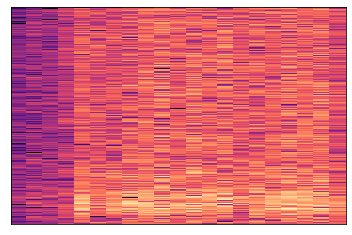

In [54]:
disc_acc = []
gen_loss = [0]
gan_acc = []
for e in range(50):
    g_accuracy = 0
    d_accuracy = 0
    print("Step", e)
    if d_accuracy < 1:
        i, o = get_generator_outputs(stft_white_dataset_real, discriminator_train_size, gan.g, nperseg, stft_clean_dataset_real)
    gan.block_generator()
    print("Training the discriminator")
    s = 0
    err = evaluate_generator(gan.g, stft_white_dataset_real, stft_clean_dataset_real, 100)
    while d_accuracy < 0.95 and s<10:
        d_accuracy = train_on_batch(gan.d, i, o, verbose=True)
        disc_acc.append(d_accuracy)
        gan_acc.append(0)
        s+=1
        gen_loss.append(err)
    gan.block_discriminator()
    print("Training the generator")
    s = 0
    while g_accuracy < 0.95 and s<30:
        view_output(stft_white_dataset_real, gan,p)
        s+=1
        p+=1
        g_accuracy = train_on_batch(gan.combined_network, stft_white_dataset_real[:generator_train_size], np.ones(generator_train_size), batch_size=4, verbose=True)
        gan_acc.append(g_accuracy)
        disc_acc.append(0)
        err = evaluate_generator(gan.g, stft_white_dataset_real, stft_clean_dataset_real, 100)
        print(err)
        gen_loss.append(err)
    #print(evaluate_generator(gan.g, white_dataset, clean_dataset))
plt.plot(disc_acc)
plt.plot(gan_acc)
plt.show()
plt.plot(gen_loss[1:])
plt.show()

In [ ]:
#gan.combined_network.save('save2/gan_with_add')

In [ ]:
Audio(a, rate=samplerate)

In [ ]:
Audio(b, rate=samplerate)